In [2]:
# Define imports and Libraries
import pandas as pd
import string
import sklearn
import matplotlib as plt
import numpy as np
df = pd.read_csv('Usecase3_Dataset.csv')
df.head()

,Label,airline,Description
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [3]:
# Convert the text to lower case
df.Description = df.Description.apply(lambda x: x.lower())

In [4]:
# Remove punctuations
df.Description = df.Description.apply(lambda x: x.translate(string.punctuation))
df.Description = df.Description.apply(lambda x: x.translate(string.digits))

In [5]:
# Check for null values
df['Label'].isnull().sum()

0

In [6]:
import io
col = ['Label', 'Description']
df = df[col]
df = df[pd.notnull(df['Description'])]
df.columns = ['Label','Description']
df['category_id'] = df['Label'].factorize()[0]
category_id_df = df[['Label','category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id','Label']].values)
df.head()

,Label,Description,category_id
0,neutral,@virginamerica what @dhepburn said.,0
1,positive,@virginamerica plus you've added commercials t...,1
2,neutral,@virginamerica i didn't today... must mean i n...,0
3,negative,@virginamerica it's really aggressive to blast...,2
4,negative,@virginamerica and it's a really big bad thing...,2


In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Label').Description.count().plot.bar(ylim = 0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [8]:
# Remove stop words
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = 'l2', encoding = 'latin-1', ngram_range = (1,2), stop_words = 'english')
features = tfidf.fit_transform(df.Description).toarray()
labels = df.category_id
features.shape

(14640, 4906)

In [9]:
from sklearn.feature_selection import chi2
N = 2
for Label, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Label))
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'negative':
 Most correlated unigrams:
. thanks
. thank
 Most correlated bigrams:
. united thank
. jetblue thanks
# 'neutral':
 Most correlated unigrams:
. http
. fleek
 Most correlated bigrams:
. jetblue fleet
. fleet fleek
# 'positive':
 Most correlated unigrams:
. thanks
. thank
 Most correlated bigrams:
. jetblue thank
. jetblue thanks


In [10]:
# import model libraries and fit the data

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Split the data for train and test

X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)

In [11]:
# Predict the Label for test string
print(clf.predict(count_vect.transform(["flight cancelled what should i do now"])))

['negative']


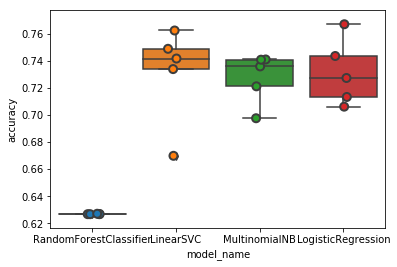

In [13]:
# Compare with multiple models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 0),
]
CV = 5
cv_df = pd.DataFrame(index = range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv = CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x = 'model_name', y = 'accuracy', data = cv_df)
sns.stripplot(x = 'model_name', y = 'accuracy', data = cv_df,
             size = 8, jitter = True, edgecolor = "gray", linewidth = 2)
plt.show()
        


In [15]:
# Accuracy comparision result
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.731221
LogisticRegression        0.731349
MultinomialNB             0.727182
RandomForestClassifier    0.626913
Name: accuracy, dtype: float64

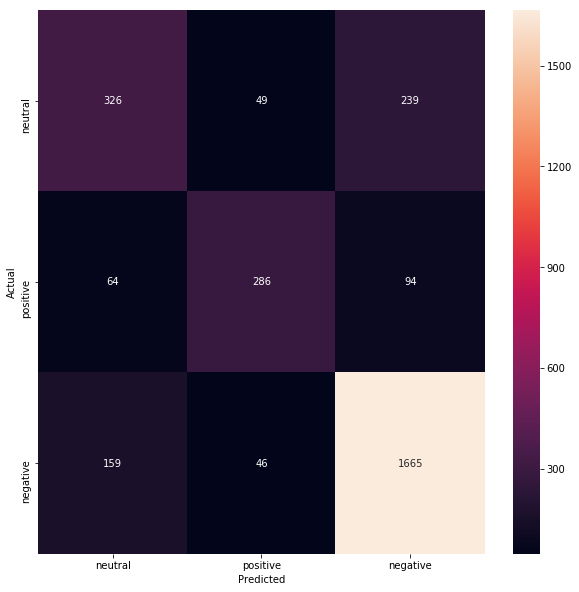

In [19]:
# Choose the best model
model = LinearSVC()
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size = 0.20, random_state = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(conf_mat, annot = True, fmt = 'd',
           xticklabels = category_id_df.Label.values, yticklabels = category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names = df['Label'].unique()))

             precision    recall  f1-score   support

    neutral       0.59      0.53      0.56       614
   positive       0.75      0.64      0.69       444
   negative       0.83      0.89      0.86      1870

avg / total       0.77      0.78      0.77      2928



In [23]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))
model = pickle.load(open("model.pkl", "rb"))